# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [65]:
import numpy as np
import os
from imageio import imread 
from skimage.transform import resize
import datetime
import os
import tensorflow.keras


In [66]:
import cv2
import matplotlib.pyplot as plt


We set the random seed so that the results don't vary drastically.

In [67]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30) 

In [68]:
cwd = os. getcwd()
print(cwd)

/home/Project


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [69]:
project_folder='/home/Project'
train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + '/' +'val.csv').readlines())
batch_size = 29



In [70]:
train_path = '/home/datasets/Project_data/train'
len(train_path)

33

In [71]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [72]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,28,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image.resize(120,120)
                    batch_data[folder,idx,:,:,0] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
    if((len(source_path)%batch_size)//2==0):
        batch_size = 2
    else:
        batch_size = 1
        num_batches = len(source_path)%batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,28,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(120, 120)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [73]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [74]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

#write your model here
#write your model here
Input_shape = (28, 100, 100, 3)
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [75]:
print("Total Params:", model.count_params())

Total Params: 86871525


In [76]:
optimiser = optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 28, 100, 100, 32)  2624      
_________________________________________________________________
activation_26 (Activation)   (None, 28, 100, 100, 32)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 100, 100, 32)  128       
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 26, 98, 98, 32)    27680     
_________________________________________________________________
activation_27 (Activation)   (None, 26, 98, 98, 32)    0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 26, 98, 98, 32)    128       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 13, 49, 49, 32)   

In [77]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [78]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [79]:
model_name = 'model_init1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [80]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 29
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2219Source path =  /home/datasets/Project_data/val ; batch size = 29

Epoch 00001: saving model to model_init1_2022-03-3016_46_46.866775/model-00001-1.60938-0.22189-1.60926-0.23276.h5
23/23 [==============================] - 42s 2s/step - loss: 1.6094 - categorical_accuracy: 0.2219 - val_loss: 1.6093 - val_categorical_accuracy: 0.2328
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2009
Epoch 00002: saving model to model_init1_2022-03-3016_46_46.866775/model-00002-1.60943-0.20090-1.60930-0.18966.h5
23/23 [==============================] - 42s 2s/step - loss: 1.6094 - categorical_accuracy: 0.2009 - val_loss: 1.6093 - val_categorical_accuracy: 0.1897
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1889
Epoch 00003: sav

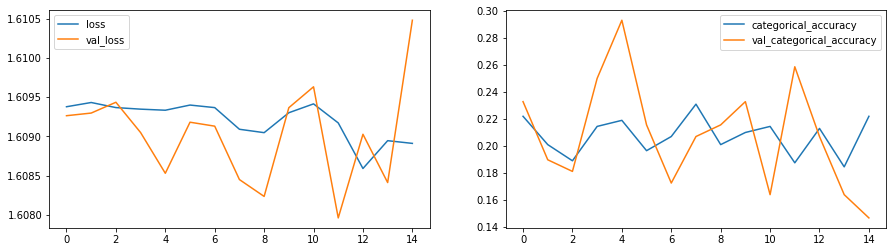

In [81]:
plot(history)

In [82]:
#Reduced number of parameters

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation

Input_shape = (28, 100, 100, 3)
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',
          input_shape = Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
       
model.add(Conv3D(16, filtersize, padding='same',
               input_shape=Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
       
model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))


model.add(Dense(5,activation='softmax'))



In [83]:
print("Total Params:", model.count_params())

Total Params: 1181493


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [84]:
optimiser = optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 28, 100, 100, 16)  1312      
_________________________________________________________________
activation_32 (Activation)   (None, 28, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 100, 100, 16)  64        
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 28, 100, 100, 16)  6928      
_________________________________________________________________
activation_33 (Activation)   (None, 28, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 28, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 14, 50, 50, 16)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [85]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [86]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [87]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [88]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 29
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1739Source path =  /home/datasets/Project_data/val ; batch size = 29

Epoch 00001: saving model to model_init_2022-03-3016_46_46.866775/model-00001-1.60952-0.17391-1.60914-0.29310.h5
23/23 [==============================] - 41s 2s/step - loss: 1.6095 - categorical_accuracy: 0.1739 - val_loss: 1.6091 - val_categorical_accuracy: 0.2931
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.2009
Epoch 00002: saving model to model_init_2022-03-3016_46_46.866775/model-00002-1.60957-0.20090-1.60965-0.16379.h5
23/23 [==============================] - 41s 2s/step - loss: 1.6096 - categorical_accuracy: 0.2009 - val_loss: 1.6097 - val_categorical_accuracy: 0.1638
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1934
Epoch 00003: savin

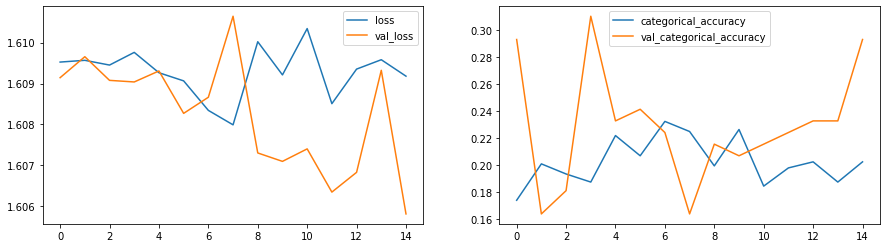

In [89]:
plot(history)

In [102]:
##Model CONV2D + LSTM

In [103]:
#write your model here
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional


Input_shape_1 = (28, 160, 160, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Flatten()))
 
model.add(Dropout(0.5))
model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_87 (TimeDis (None, 28, 80, 80, 32)    4736      
_________________________________________________________________
time_distributed_88 (TimeDis (None, 28, 78, 78, 32)    9248      
_________________________________________________________________
time_distributed_89 (TimeDis (None, 28, 39, 39, 32)    0         
_________________________________________________________________
time_distributed_90 (TimeDis (None, 28, 39, 39, 64)    18496     
_________________________________________________________________
time_distributed_91 (TimeDis (None, 28, 39, 39, 64)    36928     
_________________________________________________________________
time_distributed_92 (TimeDis (None, 28, 19, 19, 64)    0         
_________________________________________________________________
time_distributed_93 (TimeDis (None, 28, 19, 19, 128) 

In [104]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D ,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation

Input_shape = (28, 100, 100, 3)
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25
lstm_cells=64

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                 input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(GRU(lstm_cells))
model.add(Dropout(dropout))
        
model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))
        
model.add(Dense(5, activation='softmax'))

In [106]:
optimiser = tensorflow.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_103 (TimeDi (None, 28, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_104 (TimeDi (None, 28, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_105 (TimeDi (None, 28, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_106 (TimeDi (None, 28, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_107 (TimeDi (None, 28, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_108 (TimeDi (None, 28, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_109 (TimeDi (None, 28, 25, 25, 64)  

In [107]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [108]:
model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [109]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)    
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

print(steps_per_epoch)
    
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(validation_steps)    

23
4


In [110]:
history1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 29
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.1829Source path =  /home/datasets/Project_data/val ; batch size = 29

Epoch 00001: saving model to Gesture_recog_2022-03-3016_46_46.866775/model-00001-1.60955-0.18291-1.60936-0.25000.h5
23/23 [==============================] - 42s 2s/step - loss: 1.6096 - categorical_accuracy: 0.1829 - val_loss: 1.6094 - val_categorical_accuracy: 0.2500
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.1799
Epoch 00002: saving model to Gesture_recog_2022-03-3016_46_46.866775/model-00002-1.60956-0.17991-1.60933-0.19828.h5
23/23 [==============================] - 43s 2s/step - loss: 1.6096 - categorical_accuracy: 0.1799 - val_loss: 1.6093 - val_categorical_accuracy: 0.1983
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2054
Epoch 00003:

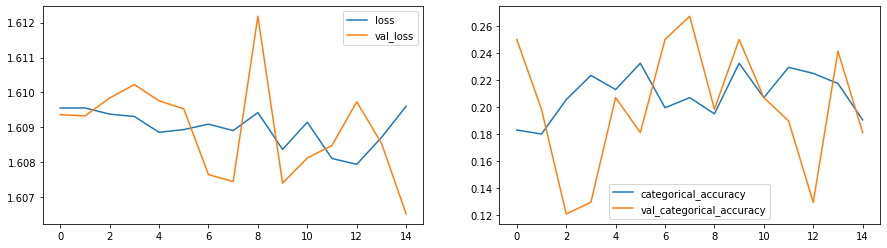

In [111]:
plot(history1)